# Evaluation Script Test 

In [1]:
using AutomotiveDrivingModels, AutoViz, Reel

Load models and config

In [2]:
include("eval-env/occluded_crosswalk.jl") # env config

CrosswalkEnv

In [3]:
include("eval-env/constant_pedestrian.jl") # pedestrian model

In [4]:
include("eval-env/pedestrian_flow.jl")

initial_pedestrian

In [5]:
include("eval-env/simple_sensor.jl")

is_observable

In [6]:
include("eval-env/ego_control.jl")

initial_ego

In [7]:
include("simulation.jl")

In [8]:
include("eval_config.jl") # eval config

is_terminal (generic function with 1 method)

In [9]:
include("baseline_policy.jl")

update

In [10]:
include("render_helpers.jl")

## Initialize 

### Configure the Evaluation
- Time step
- Number of episodes 
- ...

In [11]:
config = EvalConfig() # use default
config.time_out = 100
config.callbacks

(EgoCollisionCallback(),TerminalCallback())

In [12]:
cam = FitToContentCamera(0.0)

AutoViz.FitToContentCamera(0.0)

### Configure the Environment

In [13]:
params = EnvParams(ped_rate = 0.3)
env = CrosswalkEnv(params)

CrosswalkEnv(Roadway,AutomotiveDrivingModels.Lane(LaneTag(2, 1),AutomotiveDrivingModels.CurvePt[CurvePt({25.000, -10.000, 1.571}, 0.000, 0.000, NaN),CurvePt({25.000, 10.000, 1.571}, 20.000, 0.000, NaN)],6.0,AutomotiveDrivingModels.SpeedLimit(-Inf,Inf),AutomotiveDrivingModels.LaneBoundary(:unknown,:unknown),AutomotiveDrivingModels.LaneBoundary(:unknown,:unknown),AutomotiveDrivingModels.LaneConnection[],AutomotiveDrivingModels.LaneConnection[]),AutomotiveDrivingModels.ConvexPolygon[ConvexPolygon: len 4 (max 4 pts)
	VecE2(15.000, -1.500)
	VecE2(15.000, -4.500)
	VecE2(22.000, -4.500)
	VecE2(22.000, -1.500)
],EnvParams(2,50.0,3.0,20.0,6.0,5.0,37.0,8.0,0.3,2.0,10.0))

In [14]:
sensor = SimpleSensor(0.1, 0.1)

SimpleSensor(0.1,0.1)

## Initialize states

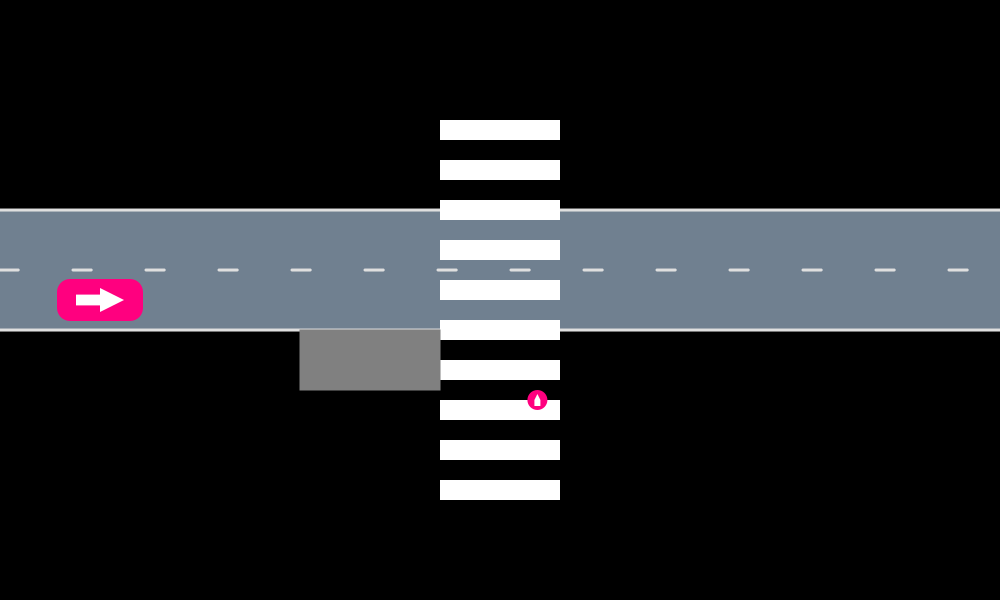

In [15]:
# Car definition
ego_initial_state = VehicleState(VecSE2(5.0, 0., 0.), env.roadway.segments[1].lanes[1],env.roadway, 8.0)
ego = Vehicle(ego_initial_state, VehicleDef(), 1)

scene = Scene()
push!(scene, ego)

ped = initial_pedestrian(env, config.rng)
push!(scene, ped)

# visualize the initial state
render(scene, env, cam=cam)

## Test with baseline policy

In [16]:
ego = initial_ego(env, config.rng)
policy = waitAndGo(env = env, initial_state = ego, Δt = config.sim_dt, N0 = 10, threshold = 3.)
updater = waitAndGoUpdater(policy);

In [17]:
overlay = WaitAndGoOverlay(config.sim_dt, 0., policy)

WaitAndGoOverlay(0.1,0.0,waitAndGo
  env: CrosswalkEnv
  initial_state: Records.Entity{AutomotiveDrivingModels.VehicleState,AutomotiveDrivingModels.VehicleDef,Int64}
  max_acc: Float64 3.0
  max_dec: Float64 -4.0
  Δt: Float64 0.1
  N0: Int64 10
  threshold: Float64 3.0
  dist_delta: Float64 1.0
  reaching: Bool true
  wait: Bool false
  go: Bool false
  N: Int64 0
,Inf,1,1,RGB{N0f8}(1.0,1.0,1.0),20)

In [18]:
function reset_policy!(policy::waitAndGo)
    policy.reaching = true
    policy.wait = false
    policy.go = false 
    policy.N = 0
end

reset_policy! (generic function with 1 method)

In [19]:
scene = Scene()
push!(scene, ego);

In [20]:
models = Dict{Int, DriverModel}()
# Constant speed model
models[1] = CrosswalkDriver(env, 0., Vehicle[], ego.state, sensor, policy, updater); 
# models[1] = IntelligentDriverModel(v_des = 8.)
# models[2] = ConstantPedestrian(0.1, 0.5, 2.0, config.sim_dt)

In [21]:
nticks = config.time_out
rec = SceneRecord(nticks+1, config.sim_dt)
# execute the simulation
for i = 1:100
    reset_policy!(policy)    
    ego = initial_ego(env, config.rng)
    overlay.speed = ego.state.v
    models[1] = CrosswalkDriver(env, 0., Vehicle[], ego.state, sensor, policy, updater) 
    scene = Scene()
    push!(scene, ego);
    simulate!(rec, scene, env, models, nticks, config.rng, config.callbacks)
    if is_crash(rec[0])
        println("Episode $i crash")
        break 
    elseif nframes(rec) == config.time_out + 1    
        println("Episode $i time out")
        break
    end
end

Episode 2 time out


In [22]:
reset_policy!(overlay.policy)
duration, fps, render_rec = animate_record(rec, overlay)
# speed_factor = 1/4
film = roll(render_rec, fps = fps*speed_factor, duration = duration/speed_factor)

Reel.Frames{MIME{Symbol("image/png")}}("C:\\Users\\Maxime\\AppData\\Local\\Temp\\jl_B314.tmp",0x0000000000000065,2.5,nothing)

## Evaluate and tune the baseline

The parameters we wish to tune are the TTC threshold and the number of redundancy

In [24]:
config.n_episodes = 100

100

In [25]:
function evaluate(th::Float64, N::Int64)
    # initialize policy to evaluate
    env.params.ped_rate = 0.2
    policy = waitAndGo(env = env, initial_state = ego, Δt = config.sim_dt, N0 = N, threshold = th)
    updater = waitAndGoUpdater(policy)

    models = Dict{Int, DriverModel}()
    # Constant speed model
    models[1] = CrosswalkDriver(env, 0., Vehicle[], ego.state, sensor, policy, updater) 

    #evaluation 
    config.n_episodes = 100
    nticks = config.time_out
    rec = SceneRecord(nticks+1, config.sim_dt)

    # intiialize containers and callbacks
    time_outs = 0
    crashes = 0
    successes = 0
    steps = zeros(config.n_episodes)


    for ep = 1:config.n_episodes

        # initialize scene
        rec = SceneRecord(nticks+1, config.sim_dt)
        reset_policy!(policy)    
        ego = initial_ego(env, config.rng)
        models[1] = CrosswalkDriver(env, 0., Vehicle[], ego.state, sensor, policy, updater) 
        scene = Scene()
        push!(scene, ego);


        simulate!(rec, scene, env, models, nticks, config.rng, config.callbacks)

        # analyze
        if rec.nframes == config.time_out + 1
            time_outs += 1
        elseif is_crash(rec[0])
            crashes += 1
        elseif is_terminal(rec[0], env)
            successes += 1
        end

        steps[ep] = nframes(rec)       

    end
    try
        @assert time_outs + crashes + successes == config.n_episodes
    catch 
        println(time_outs, " ", crashes, " ", successes, " ", time_outs + crashes + successes)
    end
    return time_outs,crashes, successes,mean(steps)
end

evaluate (generic function with 1 method)

In [26]:
using ProgressMeter

In [27]:
th_vec = 0:0.5:5
N_vec = 0:30
crashes = zeros(length(th_vec), length(N_vec))
successes = zeros(length(th_vec), length(N_vec))
time_outs = zeros(length(th_vec), length(N_vec))
steps = zeros(length(th_vec), length(N_vec))
best_succ, th_best, N_best = 0. , 0., 0.
@showprogress for (i,th) in enumerate(th_vec)
    for (j,N) in enumerate(N_vec)
        time_outs[i,j], crashes[i,j], successes[i,j], steps[i,j] = evaluate(th, N)
        if successes[i,j] > best_succ
            best_succ, th_best, N_best = successes[i,j], th, N
        end
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:01:07


In [28]:
using PyPlot

INFO: Recompiling stale cache file C:\Users\Maxime\.julia\lib\v0.5\PyCall.ji for module PyCall.
INFO: Recompiling stale cache file C:\Users\Maxime\.julia\lib\v0.5\PyPlot.ji for module PyPlot.


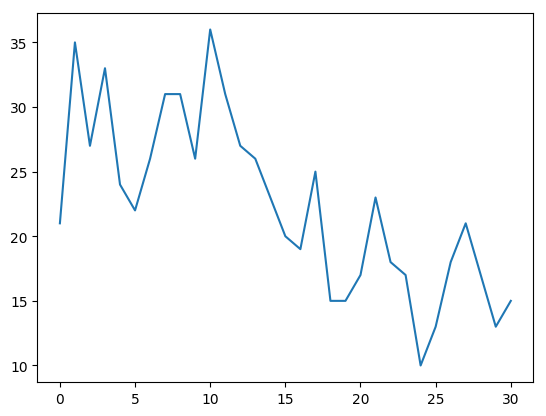

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x00000000241E02E8>

In [29]:
plot(N_vec, crashes[end,:])

In [50]:
best_succ

59.0

In [73]:
crashes[end, :]

11-element Array{Float64,1}:
 54.0
 47.0
 34.0
 37.0
 34.0
 33.0
 44.0
 36.0
 28.0
 45.0
 41.0

In [51]:
minimum(time_outs)

0.0

In [29]:
?showprogress

search: @showprogress

Couldn't find showprogress
Perhaps you meant @showprogress or Progress


No documentation found.

Binding `showprogress` does not exist.
